In [98]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import seaborn as sns
from pathlib import Path
from dotenv import load_dotenv

In [99]:
 # Read the Mapbox API key
load_dotenv()

True

In [100]:
#Bring in All the files

#Plotting Bitcoins Trajectory 
BTC_hour = pd.read_csv('data/gemini_BTCUSD_1hr.csv', skiprows=1).drop(columns=['Unix Timestamp','Symbol'])

#Bring in BTCUSD_day
BTC_day = pd.read_csv('data/gemini_BTCUSD_day.csv', skiprows=1).drop(columns=['Unix Timestamp','Symbol'])

#Convert Date to datetime
BTC_day['Date'] = pd.to_datetime(BTC_day['Date'],utc=True)
BTC_hour['Date'] = pd.to_datetime(BTC_hour['Date'],utc=True)


#Make Date index -> Clean up Data
BTC_day.set_index('Date', inplace=True)
BTC_hour.set_index('Date',inplace=True)

#Sort BTC Index
BTC_hour.sort_index(ascending=True,inplace=True)

#Bring in ALL of Elon Musks Tweets
tweets_elonmusk_all = pd.read_csv('Data/tweets_elonmusk_all_CLEAN.csv')
#Bring in and group Elon Musk Tweets about Crypto/Bitcoin
tweets_elonmusk_crypto = pd.read_csv('Data/tweets_elonmusk_crypto_CLEAN.csv')

#Convert tweet_date to datetime
tweets_elonmusk_all['tweet_date'] = pd.to_datetime(tweets_elonmusk_all['tweet_date'],utc=True)
tweets_elonmusk_crypto['tweet_date'] = pd.to_datetime(tweets_elonmusk_crypto['tweet_date'],utc=True)

#Round the tweets to the nearest hour
tweets_elonmusk_all['tweet_date'] = tweets_elonmusk_all['tweet_date'].dt.round('60min')
tweets_elonmusk_crypto['tweet_date'] = tweets_elonmusk_crypto['tweet_date'].dt.round('60min')

In [101]:
#Define Panel Visulualization Functions
def elon_musk_crypto_tweet_activity():
    #Plot the likes by day - scatter plot
    fig = px.scatter(tweets_elonmusk_crypto,x='tweet_date',y='tweet_like_count',size='tweet_retweet_count', color='tweet_reply_count', title = 'Scatter Plot of Elon Musk Crypto Tweet Activity')
    
    #Return plot
    return fig

def elon_musk_tweet_vs_bitcoin():
    #Make tweet_date the index and sort index
    EMT = tweets_elonmusk_crypto.set_index('tweet_date').sort_index(ascending=True) #EMT - Elon Musk Tweets with the tweet_date set as the index
    tweets_elonmusk_crypto.sort_index(ascending=False,inplace=True)
    
    #Filter out the hours when Elon tweeted
    filtered_BTC = EMT.merge(BTC_hour, left_on='tweet_date', right_index=True)
    
    #Plot BTC
    fig = px.line(BTC_hour, x=BTC_hour.index, y='Close', title='Elon Musk Tweet vs. Bitcoin')

    #Add a scatter plot, but the x and y corrdinates of likes in bubbles
    fig.add_trace(go.Scatter(x=filtered_BTC.index,y=filtered_BTC['Close'], mode='markers',name='Likes',marker=dict(size=tweets_elonmusk_crypto['tweet_like_count']/15000)))

    #Return plot
    return fig

def daily_returns():
    #Get daily retruns of BTC
    daily_returns = BTC_day.pct_change().dropna()
    
    daily_returns['Volume'] = daily_returns[daily_returns['Volume']<1000]

    #Plot out daily returns
    fig = daily_returns['Close'].hvplot(title='Bitcoin Daily Returns')

    #Return plot
    return fig


def hourly_returns():
    #hourly returns
    hourly_returns = BTC_hour.pct_change().dropna()
    
    #plot out hourly returns
    fig = hourly_returns['Close'].hvplot(title='Bitcoin Hourly Returns')

    #Return plot
    return fig

def elon_musk_tweet_events_daily_return():
    #Get daily retruns of BTC
    daily_returns = BTC_day.pct_change().dropna()

    daily_returns['Volume'] = daily_returns[daily_returns['Volume']<1000]
    
    #Group tweets day by day
    tweets_elonmusk_crypto_daily = tweets_elonmusk_crypto.set_index('tweet_date').groupby(pd.Grouper(freq='D')).mean().dropna()

    #Plot BTC
    fig = px.bar(daily_returns, x=daily_returns.index, y='Close', title='Daily Returns with Elon Musk Tweet Events')

    #Add a scatter plot, but the x and y corrdinates of likes in bubbles
    fig.add_trace(go.Scatter(x=tweets_elonmusk_crypto_daily.index,y=tweets_elonmusk_crypto_daily['tweet_like_count']*0, mode='markers',name='Likes', marker=dict(size=tweets_elonmusk_crypto['tweet_like_count']/10000)))

    #Add a scatter plot, but the x and y corrdinates of retweet in bubbles
    fig.add_trace(go.Scatter(x=tweets_elonmusk_crypto_daily.index,y=tweets_elonmusk_crypto_daily['tweet_retweet_count']*0, mode='markers',name='Retweets', marker=dict(size=tweets_elonmusk_crypto['tweet_retweet_count']/10000)))


    #Return plot
    return fig

def elon_musk_tweet_events_daily_change_volume():
    #Get daily retruns of BTC
    daily_returns = BTC_day.pct_change().dropna()

    daily_returns['Volume'] = daily_returns[daily_returns['Volume']<1000]
    
    #Group tweets day by day
    tweets_elonmusk_crypto_daily = tweets_elonmusk_crypto.set_index('tweet_date').groupby(pd.Grouper(freq='D')).mean().dropna()

    #Plot BTC
    fig = px.bar(daily_returns, x=daily_returns.index, y='Volume', title='Daily Change in Volume with Elon Musk Tweet Events')

    #Add a scatter plot, but the x and y corrdinates of likes in bubbles
    fig.add_trace(go.Scatter(x=tweets_elonmusk_crypto_daily.index,y=tweets_elonmusk_crypto_daily['tweet_like_count']*0, mode='markers',name='Likes', marker=dict(size=tweets_elonmusk_crypto['tweet_like_count']/10000)))

    #Add a scatter plot, but the x and y corrdinates of retweet in bubbles
    fig.add_trace(go.Scatter(x=tweets_elonmusk_crypto_daily.index,y=tweets_elonmusk_crypto_daily['tweet_retweet_count']*0, mode='markers',name='Retweets', marker=dict(size=tweets_elonmusk_crypto['tweet_retweet_count']/10000)))


    #Return plot
    return fig

def correlation_heatmap_daily():
    #Group Elon's Tweet like count by day
    elon_daily_tweet_count = tweets_elonmusk_all.set_index('tweet_date').groupby(pd.Grouper(freq='D')).sum()

    #Drop all zeros
    elon_daily_tweet_count.replace(0,np.nan,inplace=True)
    elon_daily_tweet_count.dropna(inplace=True)
    elon_daily_tweet_count.head()
    
    #Get daily retruns of BTC
    daily_returns = BTC_day.pct_change().dropna()

    daily_returns['Volume'] = daily_returns[daily_returns['Volume']<1000]
    
    #Normalize Date portion of daily returns for daily_returns as daily dataframe
    daily=daily_returns
    daily.index = daily_returns.index.normalize()

    #Combine daily_returns with Elon Musk Tweets Daily
    daily_returns_and_elon_tweets = pd.concat([daily,elon_daily_tweet_count],axis=1,join='inner')
    daily_returns_and_elon_tweets #.drop(columns=['Open','High','Low','Close','tweet_reply_count','tweet_retweet_count'],inplace=True)

    #Correlate the two findings
    correlation = daily_returns_and_elon_tweets.corr()
    correlation

    #Plot Correlation Plot
    fig, ax = plt.subplots()
    ax.set_title('Correlation Heat Map - Elon Tweets vs. BTC Price Action - Daily')
    sns.heatmap(correlation,vmin=-1,vmax=1,ax=ax)

    #Return plot
    return fig


def correlation_heatmap_hourly():
    #Group Elon's Tweet like count by day
    elon_daily_tweet_count = tweets_elonmusk_all.set_index('tweet_date').groupby(pd.Grouper(freq='D')).sum()

    #Drop all zeros
    elon_daily_tweet_count.replace(0,np.nan,inplace=True)
    elon_daily_tweet_count.dropna(inplace=True)
    elon_daily_tweet_count.head()
    
    #Filtering Elon's twitter data
    EMT = tweets_elonmusk_crypto.set_index('tweet_date').sort_index(ascending=True)
    
    #Filtered Bitcoin data for the days Elon tweets
    filtered_BTC = EMT.merge(BTC_hour, left_on='tweet_date', right_index=True)

    
    #hourly returns
    hourly_returns = BTC_hour.pct_change().dropna()

    #Normalize Date portion of daily returns for hourly_returns as hourly dataframe
    hourly=hourly_returns

    #Combine daily_returns with Elon Musk Tweets Hourly
    hourly_returns_and_elon_tweets = hourly.merge(filtered_BTC, left_on='Date', right_index=True)
    hourly_returns_and_elon_tweets.drop(columns=['Open_y','High_y','Low_y','Close_y','Volume_y','twitter_username','twitter_account','tweet_content'], inplace=True)
    hourly_correlation = hourly_returns_and_elon_tweets.corr()

    #Plot Correlation Plot
    fig, ax = plt.subplots()
    ax.set_title('Correlation Heat Map - Elon Tweets vs. BTC Price Action - Hourly')
    sns.heatmap(hourly_correlation,vmin=-1,vmax=1,ax=ax)

    #Return plot
    return fig

def correlation_heatmap_2020_2021():
    #Group Elon's Tweet like count by day
    elon_daily_tweet_count = tweets_elonmusk_all.set_index('tweet_date').groupby(pd.Grouper(freq='D')).sum()

    #Drop all zeros
    elon_daily_tweet_count.replace(0,np.nan,inplace=True)
    elon_daily_tweet_count.dropna(inplace=True)
    elon_daily_tweet_count.head()
    
    #Filtering Elon's twitter data
    EMT = tweets_elonmusk_crypto.set_index('tweet_date').sort_index(ascending=True)
    
    #Filtered Bitcoin data for the days Elon tweets
    filtered_BTC = EMT.merge(BTC_hour, left_on='tweet_date', right_index=True)
    
    #hourly returns
    hourly_returns = BTC_hour.pct_change().dropna()   

    
    #Compare Elon's tweets for 2020 vs. 2021

    #Normalize Date portion of daily returns for hourly_returns as hourly dataframe
    hourly=hourly_returns

    #Combine daily_returns with Elon Musk Tweets Hourly
    hourly_returns_and_elon_tweets = hourly.merge(filtered_BTC, left_on='Date', right_index=True)
    hourly_returns_and_elon_tweets.drop(columns=['Open_y','High_y','Low_y','Close_y','Volume_y','twitter_username','twitter_account','tweet_content'], inplace=True)

    #Filter out elon's tweets for only 2020-2021
    hourly_returns_and_elon_tweets = hourly_returns_and_elon_tweets.loc['2020':'2021']

    #Create the correlation
    hourly_correlation = hourly_returns_and_elon_tweets.corr()

    #Plot Correlation Plot
    fig, ax = plt.subplots()
    ax.set_title('Correlation Heat Map - Elon Tweets vs. BTC Price Action - 2020/2021')
    sns.heatmap(hourly_correlation,vmin=-1,vmax=1,ax=ax)

    #Return plot
    return fig




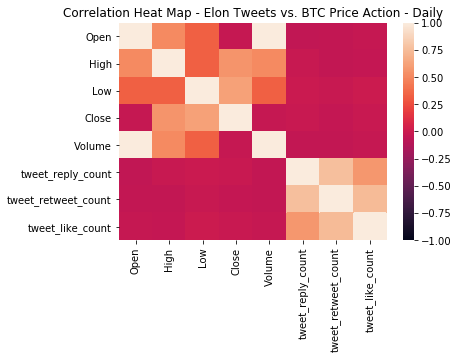

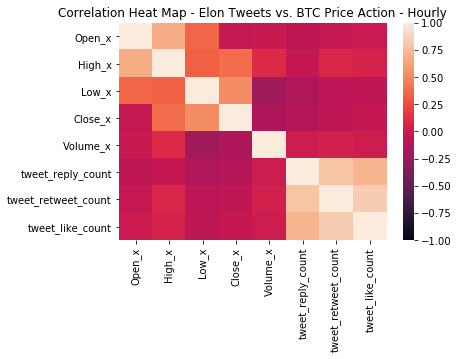

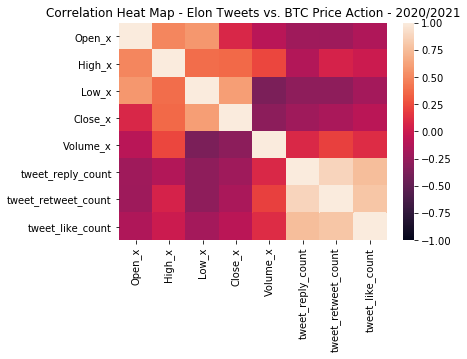

In [102]:
#Create a Title for the Dashboard
#Create a tab layout for the dashboard
daily_returns_and_volume = pn.Column(
    elon_musk_tweet_events_daily_return(),
    elon_musk_tweet_events_daily_change_volume()
)

returns = pn.Row(
    daily_returns(),
    hourly_returns()
)

heatmap_normal = pn.Row(
    correlation_heatmap_daily(),
    correlation_heatmap_hourly()
)

heatmaps = pn.Column(
    heatmap_normal,
    correlation_heatmap_2020_2021()
)



elon_btc_analysis_dashboard = pn.Tabs(
    ("Scatter Plot | Elon Musk Crypto Tweet Activity",elon_musk_crypto_tweet_activity()),
    ("Elon Musk Tweet vs. Bitcoin", elon_musk_tweet_vs_bitcoin()),
    ("Returns",returns),
    ('Daily Returns | Daily Change in Volume',daily_returns_and_volume),
    ("Correlation Heatmaps", heatmaps)
)

Tabs
    [0] Plotly(Figure, name='Scatter Plot |...)
    [1] Plotly(Figure, name='Elon Musk Tweet v...)
    [2] Row
        [0] HoloViews(Curve)
        [1] HoloViews(Curve)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
    [4] Column
        [0] Row
            [0] Matplotlib(Figure)
            [1] Matplotlib(Figure)
        [1] Matplotlib(Figure)
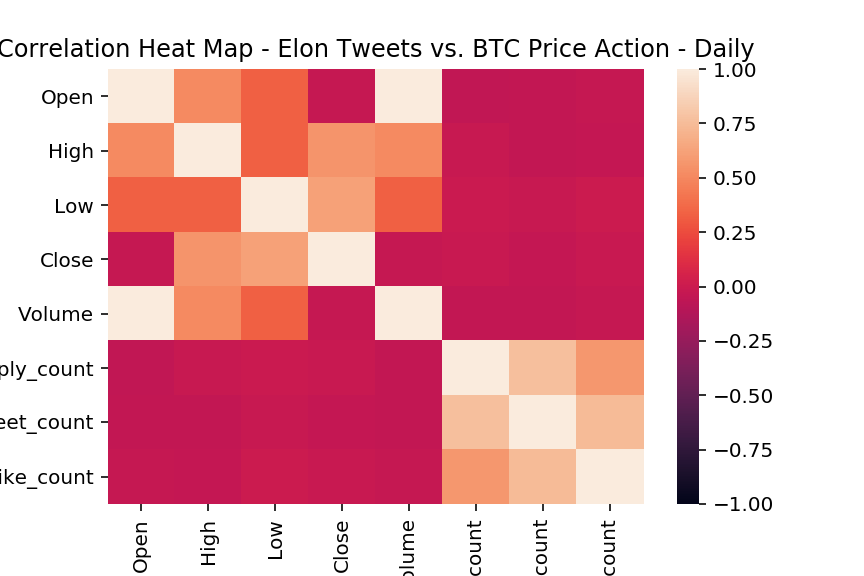
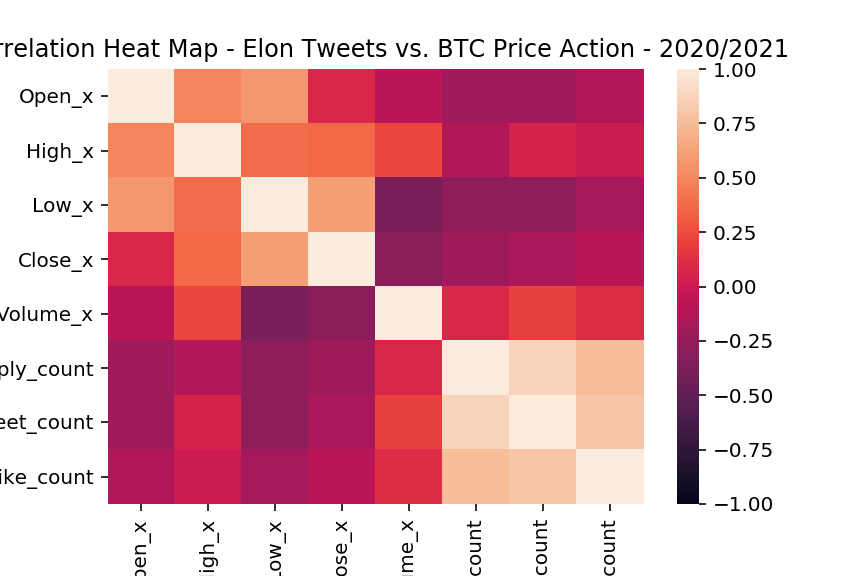
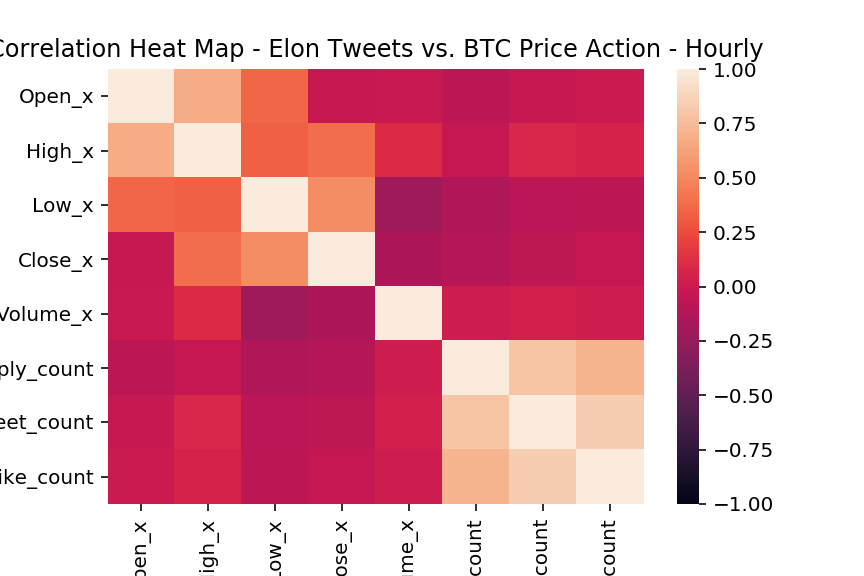

In [103]:
#Serve the dashboard
elon_btc_analysis_dashboard